# LLM-Powered Sentiment Analyzer for Financial News

This Jupyter Notebook uses OpenAI's language models to analyze sentiment in financial news articles regarding recession fears in the US economy. It fetches articles from NewsAPI, processes them, and then uses the language model to assess sentiment. The analysis covers the past month, processing up to 10 articles per day, as NewsAPI only provides data for the last 30 days.

---

## **1. Import Required Libraries**

In this cell, I import all the necessary libraries for data processing, API interactions, and web scraping.


In [2]:
import os
import time
import re
from datetime import datetime, timedelta
import pandas as pd
import requests
from bs4 import BeautifulSoup
import tiktoken  
import openai
from openai import OpenAI
from newsapi import NewsApiClient
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## **2. Set Up API Keys**

In this cell, I initialize the OpenAI and NewsAPI clients.

In [3]:
OPENAI_API_KEY = 'OPENAI_API_KEY'
NEWSAPI_KEY = 'NEWSAPI_KEY'

client = OpenAI(api_key=OPENAI_API_KEY)
newsapi = NewsApiClient(api_key=NEWSAPI_KEY)

---

## **3. Define the List of Sectors**

Idefine a list of sectors to extract from the articles for sector-wise sentiment analysis.

In [4]:
SECTORS = [
    'Technology', 'Energy', 'Healthcare', 'Financials', 'Consumer Discretionary',
    'Consumer Staples', 'Industrials', 'Materials', 'Utilities', 'Real Estate',
    'Communication Services', 'Telecommunications', 'Information Technology',
    'Consumer Goods', 'Basic Materials', 'Transportation', 'Retail', 'Automotive',
    'Aerospace', 'Defense', 'Pharmaceuticals', 'Biotechnology', 'Banking',
    'Insurance', 'Media', 'Entertainment', 'Food & Beverage', 'Hospitality',
    'Tourism', 'Agriculture', 'Construction', 'Chemicals', 'Metals & Mining',
    'Oil & Gas', 'Renewable Energy', 'Software', 'Hardware', 'E-commerce'
]

---

## **4. Function to Log LLM Interactions**

The log_llm_interaction function saves each prompt sent to the LLM and the corresponding response to a text file llm_interactions.txt. This allows to review the interactions later.


In [5]:
def log_llm_interaction(prompt, response, log_file='llm_interactions.txt'):
    with open(log_file, 'a', encoding='utf-8') as file:
        file.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        file.write("----- Prompt -----\n")
        file.write(prompt + "\n")
        file.write("----- Response -----\n")
        file.write(response + "\n")
        file.write("========================================\n\n")

---

## **5. Function to Fetch Articles Over Time**

The get_articles_over_time function fetches articles from NewsAPI within a specified date range. 

Parameters:

- query: The search query for articles.
- language: Language of the articles.
- from_date: Start date for fetching articles.
- to_date: End date for fetching articles.
- page_size: Number of articles per page.

In [6]:
def get_articles_over_time(query='US equity market', language='en', from_date=None, to_date=None, page_size=10):

    all_articles = []
    page = 1
    max_pages = 5 

    while page <= max_pages:
        try:
            print(f'Fetching articles: Page {page}')
            articles = newsapi.get_everything(
                q=query,
                language=language,
                from_param=from_date,
                to=to_date,
                sort_by='relevancy',
                page_size=page_size,
                page=page
            )
            fetched_articles = articles.get('articles', [])
           
            if not fetched_articles:
                print('No more articles found.')
                break
            all_articles.extend(fetched_articles)

            if len(all_articles) >= 100:
                print('Reached maximum number of articles allowed by NewsAPI.')
                break

            page += 1
            time.sleep(1) 

        except Exception as e:
            print(f'Error during NewsAPI call: {e}')
            break
    print(f'Total number of articles fetched: {len(all_articles)}')
    return all_articles

---

## **6. Convert Articles to DataFrame**

The articles_to_dataframe function converts the list of articles fetched from NewsAPI into a pandas DataFrame for easier processing.

In [7]:
def articles_to_dataframe(articles):
    df = pd.DataFrame([{
        'title': article.get('title'),
        'source': article.get('source', {}).get('name'),
        'url': article.get('url'),
        'published_at': article.get('publishedAt')
    } for article in articles])
    return df

---

## **7. Clean Text Function**

The clean_text function removes HTML tags, scripts, styles, and unnecessary whitespace from the article content.



In [8]:
def clean_text(text):
    soup = BeautifulSoup(text, 'html.parser')
    for script in soup(["script", "style", "header", "footer", "nav"]):
        script.decompose()
    clean = soup.get_text(separator=' ')
    clean = re.sub(r'\s+', ' ', clean).strip()
    return clean

---

## **8. Scrape Full Article Content**

The scrape_full_article function fetches the full content of an article given its URL and cleans it using the clean_text function.


In [9]:
def scrape_full_article(url):
    try:
        headers = {'User-Agent': 'Mozilla/5.0'} 
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            clean = clean_text(response.text)
            return clean
        else:
            print(f'Error accessing article: {response.status_code} - URL: {url}')
            return None
    except Exception as e:
        print(f'Error fetching article: {e} - URL: {url}')
        return None

---

## **9. Sentiment and Sector Analysis Function**

The `get_sentiment_and_sectors` function is designed to send the cleaned article text to OpenAI's language model to obtain a sentiment score, a confidence score, and to identify sectors mentioned in the article concerning recession fears in the U.S. economy.


- **Prompt:** Initially, I noticed that the OpenAI API was being used inefficiently, leading to unnecessary token usage and increased costs. To address this issue, I optimized the prompt to reduce the token count without compromising the quality of the analysis. This involved refining the instructions and ensuring that only essential information was included.

- **Token Limit Management:** The function includes a mechanism to check if the prompt exceeds the model's maximum token limit. If the text is too long, it truncates it to ensure it fits within the allowable range, preventing errors due to exceeding token limits.

- **Error Handling:** Robust error handling is implemented to manage API rate limits, timeouts, and other potential issues. This ensures that the script can retry requests or terminate appropriately without data loss or interruptions in the data processing pipeline.

- **Interaction Logging:** For transparency and ease of debugging, each prompt sent to the language model and its corresponding response are logged in the `llm_interactions.txt` file. This allows me to review the interactions, troubleshoot any issues, and maintain a record of the analysis performed.

In [10]:
def get_sentiment(text):

    max_retries = 5
    base_delay = 1 
    sectors_list = ', '.join(SECTORS)

    for attempt in range(max_retries):
        try:
            prompt = (
                "You are a seasoned economist specializing in analyzing financial news articles to assess sentiment regarding recession fears in the US economy. "
                "Your expertise includes understanding macroeconomic indicators, market trends, and fiscal policies. "
                "When analyzing the following article, please consider the broader economic context, recent economic data, and any mentioned policies or market movements. "
                "Provide the following based on your analysis:\n"
                "1. A sentiment score as a single decimal number between -1 and +1, where:\n"
                "   -1 indicates a strong belief that the US economy is recession-safe,\n"
                "    0 indicates a neutral stance, and\n"
                "   +1 indicates significant fears of an impending recession.\n"
                "   Include decimal values to reflect the intensity of the sentiment.\n"
                "2. A confidence score between 0 and 1 indicating your confidence in the assessment, considering the clarity and volume of relevant information in the article.\n"
                "3. The most relevant sectors from the provided list that are significantly discussed or impacted in the article. Provide your answer as a comma-separated list.\n"
                f"Sectors List:\n{sectors_list}\n\n"
                "Ensure that your analysis accounts for factors such as GDP growth rates, unemployment figures, consumer confidence indexes, and any notable shifts in fiscal or monetary policy mentioned in the article.\n"
                "Format your response exactly as follows, without any additional commentary:\n"
                "'Sentiment Score: [value], Confidence Score: [value], Sectors: [list of sectors]'\n\n"
                f"{text}"
            )

            encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
            prompt_tokens = len(encoding.encode(prompt))
            max_tokens_model = 4096

            if prompt_tokens > max_tokens_model - 500:
                allowed_tokens = max_tokens_model - 500 - len(encoding.encode(prompt.split('\n\n')[0]))
                truncated_text = encoding.decode(encoding.encode(text)[:allowed_tokens])
                prompt = prompt.split('\n\n')[0] + "\n\n" + truncated_text
                print("Prompt truncated to fit the model's maximum context length.")

            response = client.chat.completions.create(model="gpt-3.5-turbo",
            messages=[
                {"role": "user", "content": prompt}
            ],
            max_tokens=150,
            temperature=0.0)

            reply = response.choices[0].message.content.strip()
            log_llm_interaction(prompt, reply)

            sentiment_match = re.search(r"Sentiment Score:\s*([-+]?\d*\.\d+|\d+)", reply)
            confidence_match = re.search(r"Confidence Score:\s*([-+]?\d*\.\d+|\d+)", reply)
            sectors_match = re.search(r"Sectors:\s*(.*)", reply)

            if sentiment_match and confidence_match and sectors_match:
                sentiment_score = float(sentiment_match.group(1))
                confidence_score = float(confidence_match.group(1))
                sectors_raw = sectors_match.group(1)
                extracted_sectors = [sector.strip() for sector in sectors_raw.split(',') if sector.strip() in SECTORS]
                return sentiment_score, confidence_score, extracted_sectors
            else:
                print(f'Could not parse sentiment, confidence scores, or sectors from response: {reply}')
                return None, None, []

        except openai.RateLimitError as e:
            print(f'Rate limit error: {e}')
            sleep_time = min(base_delay * (2 ** attempt) + random.uniform(0, 1), 60)
            print(f'Rate limit reached. Retrying in {sleep_time:.2f} seconds...')
            time.sleep(sleep_time)
        except openai.Timeout as e:
            print(f'Timeout error: {e}')
            sleep_time = 60  
            print(f'No response received. Retrying in {sleep_time} seconds...')
            time.sleep(sleep_time)
        except Exception as e:
            print(f'Error during OpenAI API call: {e}')
            return None, None, []


    print('Max retries exceeded for OpenAI API call.')
    return None, None, []

In [ ]:
def get_sentiment(text):

    # Step 1: Set Up Variables
    max_retries = 5                 
    base_delay = 1                  
    sectors_list = ', '.join(SECTORS) 

    # Step 2: Construct Prompt
    for attempt in range(max_retries):
        try:
            prompt = (
                "You are a seasoned economist specializing in analyzing financial news articles to assess sentiment regarding recession fears in the US economy. "
                "Your expertise includes understanding macroeconomic indicators, market trends, and fiscal policies. "
                "When analyzing the following article, please consider the broader economic context, recent economic data, and any mentioned policies or market movements. "
                "Provide the following based on your analysis:\n"
                "1. A sentiment score as a single decimal number between -1 and +1, where:\n"
                "   -1 indicates a strong belief that the US economy is recession-safe,\n"
                "    0 indicates a neutral stance, and\n"
                "   +1 indicates significant fears of an impending recession.\n"
                "   Include decimal values to reflect the intensity of the sentiment.\n"
                "2. A confidence score between 0 and 1 indicating your confidence in the assessment, considering the clarity and volume of relevant information in the article.\n"
                "3. The most relevant sectors from the provided list that are significantly discussed or impacted in the article. Provide your answer as a comma-separated list.\n"
                f"Sectors List:\n{sectors_list}\n\n"
                "Ensure that your analysis accounts for factors such as GDP growth rates, unemployment figures, consumer confidence indexes, and any notable shifts in fiscal or monetary policy mentioned in the article.\n"
                "Format your response exactly as follows, without any additional commentary:\n"
                "'Sentiment Score: [value], Confidence Score: [value], Sectors: [list of sectors]'\n\n"
                f"{text}"
            )

            # Step 3: Token Calculation and Truncation (If needed)
            encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
            prompt_tokens = len(encoding.encode(prompt))
            max_tokens_model = 4096

            if prompt_tokens > max_tokens_model - 500:
                allowed_tokens = max_tokens_model - 500 - len(encoding.encode(prompt.split('\n\n')[0]))
                truncated_text = encoding.decode(encoding.encode(text)[:allowed_tokens])
                prompt = prompt.split('\n\n')[0] + "\n\n" + truncated_text
                print("Prompt truncated to fit the model's maximum context length.")

            # Step 4: Send Request to OpenAI API
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[{"role": "user", "content": prompt}],
                max_tokens=150,
                temperature=0.0
            )

            # Step 5: Log Interaction
            reply = response.choices[0].message.content.strip()
            log_llm_interaction(prompt, reply)

            # Step 6: Parse API Response
            sentiment_match = re.search(r"Sentiment Score:\s*([-+]?\d*\.\d+|\d+)", reply)
            confidence_match = re.search(r"Confidence Score:\s*([-+]?\d*\.\d+|\d+)", reply)
            sectors_match = re.search(r"Sectors:\s*(.*)", reply)

            if sentiment_match and confidence_match and sectors_match:
                sentiment_score = float(sentiment_match.group(1))
                confidence_score = float(confidence_match.group(1))
                sectors_raw = sectors_match.group(1)
                extracted_sectors = [sector.strip() for sector in sectors_raw.split(',') if sector.strip() in SECTORS]
                return sentiment_score, confidence_score, extracted_sectors
            else:
                print(f'Could not parse sentiment, confidence scores, or sectors from response: {reply}')
                return None, None, []

        # Step 7: Handle Errors with Exponential Backoff
        except openai.RateLimitError as e:
            print(f'Rate limit error: {e}')
            sleep_time = min(base_delay * (2 ** attempt) + random.uniform(0, 1), 60)
            print(f'Rate limit reached. Retrying in {sleep_time:.2f} seconds...')
            time.sleep(sleep_time)
        
        except openai.Timeout as e:
            print(f'Timeout error: {e}')
            sleep_time = 60  
            print(f'No response received. Retrying in {sleep_time} seconds...')
            time.sleep(sleep_time)
        
        except Exception as e:
            print(f'Error during OpenAI API call: {e}')
            return None, None, []

    # Step 8: Max Retries Exceeded
    print('Max retries exceeded for OpenAI API call.')
    return None, None, []


---

## **10. Analyze Articles Over Time**

The analyze_articles_over_time function processes articles over a specified date range, performs sentiment analysis, and aggregates the results.

Key steps:

- **Load Existing Data**: Checks if sentiment_timeseries.csv exists to avoid reprocessing dates.
- **Iterate Over Dates**: For each date, fetches articles and processes up to 10 articles per day.
- **Sentiment Analysis**: For each article, retrieves the full text, performs sentiment analysis, and extracts sectors mentioned.
- **Aggregate Results**: Computes average sentiment and confidence scores per day and per sector.
- **Save Results**: Writes the aggregated data to CSV files (sentiment_timeseries.csv and sector_sentiment_timeseries.csv).

In [11]:
def analyze_articles_over_time(start_date, end_date, sentiment_csv='sentiment_timeseries.csv'):
    if os.path.exists(sentiment_csv):
        sentiment_df = pd.read_csv(sentiment_csv)
        processed_dates = set(sentiment_df['date'].astype(str).tolist())
        print(f'Loaded existing sentiment data. Dates already processed: {processed_dates}')
    else:
        sentiment_df = pd.DataFrame(columns=['date', 'sentiment_score', 'confidence_score'])
        processed_dates = set()

    current_date = start_date
    delta = timedelta(days=1)
    new_sentiments = []
    sector_sentiments = []

    while current_date <= end_date:
        date_str = current_date.strftime("%Y-%m-%d")
        if date_str in processed_dates:
            print(f'Date {date_str} already processed. Skipping.')
            current_date += delta
            continue

        next_date = current_date + delta
        print(f'Analyzing articles for date: {date_str}')
        articles = get_articles_over_time(
            from_date=current_date.strftime('%Y-%m-%d'),
            to_date=next_date.strftime('%Y-%m-%d'),
            page_size=10
        )
        if articles:
            news_df = articles_to_dataframe(articles)
            daily_sentiments = []
            for index, row in news_df.iterrows():
                if index >= 10:
                    break
                article_num = index + 1
                print(f'Processing article {article_num} on {date_str}: {row["title"]}')
                full_article = scrape_full_article(row['url'])
                if full_article:
                    sentiment_score, confidence_score, sectors = get_sentiment(full_article)
                    if sentiment_score is not None and confidence_score is not None:
                        print(f'Sentiment score for article {article_num} on {date_str}: {sentiment_score}, Confidence: {confidence_score}')
                        print(f'Sectors for article {article_num} on {date_str}: {sectors}')
                        daily_sentiments.append({'sentiment_score': sentiment_score, 'confidence_score': confidence_score})
                        for sector in sectors:
                            sector_sentiments.append({
                                'date': date_str,
                                'sector': sector,
                                'sentiment_score': sentiment_score,
                                'confidence_score': confidence_score
                            })
                    else:
                        print(f'Could not get sentiment for article {article_num} on {date_str}')
                else:
                    print(f'Could not retrieve full article {article_num} on {date_str}')
                time.sleep(1)
            if daily_sentiments:
                avg_sentiment = sum(d['sentiment_score'] for d in daily_sentiments) / len(daily_sentiments)
                avg_confidence = sum(d['confidence_score'] for d in daily_sentiments) / len(daily_sentiments)
                new_sentiments.append({
                    'date': date_str,
                    'sentiment_score': avg_sentiment,
                    'confidence_score': avg_confidence
                })
                print(f'Average sentiment for {date_str}: {avg_sentiment}, Average confidence: {avg_confidence}')
            else:
                print(f'No sentiments collected for date: {date_str}')
        else:
            print(f'No articles found for date: {date_str}')
        current_date = next_date

    if new_sentiments:
        new_sentiment_df = pd.DataFrame(new_sentiments)
        sentiment_df = pd.concat([sentiment_df, new_sentiment_df], ignore_index=True)
        sentiment_df.sort_values('date', inplace=True)
        sentiment_df.to_csv(sentiment_csv, index=False)
        print(f'Sentiment data saved to {sentiment_csv}')
    else:
        print('No new sentiment data to save.')

    if sector_sentiments:
        sector_sentiment_df = pd.DataFrame(sector_sentiments)
        sector_sentiment_csv = 'sector_sentiment_timeseries.csv'
        if os.path.exists(sector_sentiment_csv):
            existing_sector_df = pd.read_csv(sector_sentiment_csv)
            sector_sentiment_df = pd.concat([existing_sector_df, sector_sentiment_df], ignore_index=True)

        sector_sentiment_df = sector_sentiment_df.groupby(['date', 'sector'], as_index=False).agg({
            'sentiment_score': 'mean',
            'confidence_score': 'mean'
        })
        sector_sentiment_df.sort_values(['date', 'sector'], inplace=True)
        sector_sentiment_df.to_csv(sector_sentiment_csv, index=False)
        print(f'Sector sentiment data saved to {sector_sentiment_csv}')
    else:
        print('No sector sentiment data to save.')

    return sentiment_df


In [ ]:
def analyze_articles_over_time(start_date, end_date, sentiment_csv='sentiment_timeseries.csv'):
    
    # Step 1: Check for Existing Sentiment Data
    if os.path.exists(sentiment_csv):
        sentiment_df = pd.read_csv(sentiment_csv)
        processed_dates = set(sentiment_df['date'].astype(str).tolist())
        print(f'Loaded existing sentiment data. Dates already processed: {processed_dates}')
    else:
        sentiment_df = pd.DataFrame(columns=['date', 'sentiment_score', 'confidence_score'])
        processed_dates = set()

    # Step 2: Initialize Date Variables
    current_date = start_date
    delta = timedelta(days=1)
    new_sentiments = []
    sector_sentiments = []

    # Step 3: Loop Through Dates
    while current_date <= end_date:
        date_str = current_date.strftime("%Y-%m-%d")
        if date_str in processed_dates:
            print(f'Date {date_str} already processed. Skipping.')
            current_date += delta
            continue

        next_date = current_date + delta
        print(f'Analyzing articles for date: {date_str}')
        
        # Step 4:  Fetch Articles for the Date
        articles = get_articles_over_time(
            from_date=current_date.strftime('%Y-%m-%d'),
            to_date=next_date.strftime('%Y-%m-%d'),
            page_size=10
        )
        

        # Step 5: Process Each Article and Analyze Sentiment
        if articles:
            news_df = articles_to_dataframe(articles)
            daily_sentiments = []
            for index, row in news_df.iterrows():
                if index >= 10:
                    break
                article_num = index + 1
                print(f'Processing article {article_num} on {date_str}: {row["title"]}')
                full_article = scrape_full_article(row['url'])
                if full_article:
                    sentiment_score, confidence_score, sectors = get_sentiment(full_article)
                    if sentiment_score is not None and confidence_score is not None:
                        print(f'Sentiment score for article {article_num} on {date_str}: {sentiment_score}, Confidence: {confidence_score}')
                        print(f'Sectors for article {article_num} on {date_str}: {sectors}')
                        daily_sentiments.append({'sentiment_score': sentiment_score, 'confidence_score': confidence_score})
                        for sector in sectors:
                            sector_sentiments.append({
                                'date': date_str,
                                'sector': sector,
                                'sentiment_score': sentiment_score,
                                'confidence_score': confidence_score
                            })
                    else:
                        print(f'Could not get sentiment for article {article_num} on {date_str}')
                else:
                    print(f'Could not retrieve full article {article_num} on {date_str}')
                time.sleep(1)
                
            # Step 6: Calculate and Store Daily Averages
            if daily_sentiments:
                avg_sentiment = sum(d['sentiment_score'] for d in daily_sentiments) / len(daily_sentiments)
                avg_confidence = sum(d['confidence_score'] for d in daily_sentiments) / len(daily_sentiments)
                new_sentiments.append({
                    'date': date_str,
                    'sentiment_score': avg_sentiment,
                    'confidence_score': avg_confidence
                })
                print(f'Average sentiment for {date_str}: {avg_sentiment}, Average confidence: {avg_confidence}')
            else:
                print(f'No sentiments collected for date: {date_str}')
        else:
            print(f'No articles found for date: {date_str}')
        
        current_date = next_date

    # Step 7: Save Daily Sentiment Data
    if new_sentiments:
        new_sentiment_df = pd.DataFrame(new_sentiments)
        sentiment_df = pd.concat([sentiment_df, new_sentiment_df], ignore_index=True)
        sentiment_df.sort_values('date', inplace=True)
        sentiment_df.to_csv(sentiment_csv, index=False)
        print(f'Sentiment data saved to {sentiment_csv}')
    else:
        print('No new sentiment data to save.')

    # Step 8: Save Sector-Specific Sentiment Data
    if sector_sentiments:
        sector_sentiment_df = pd.DataFrame(sector_sentiments)
        sector_sentiment_csv = 'sector_sentiment_timeseries.csv'
        if os.path.exists(sector_sentiment_csv):
            existing_sector_df = pd.read_csv(sector_sentiment_csv)
            sector_sentiment_df = pd.concat([existing_sector_df, sector_sentiment_df], ignore_index=True)

        sector_sentiment_df = sector_sentiment_df.groupby(['date', 'sector'], as_index=False).agg({
            'sentiment_score': 'mean',
            'confidence_score': 'mean'
        })
        sector_sentiment_df.sort_values(['date', 'sector'], inplace=True)
        sector_sentiment_df.to_csv(sector_sentiment_csv, index=False)
        print(f'Sector sentiment data saved to {sector_sentiment_csv}')
    else:
        print('No sector sentiment data to save.')

    # Step 9: Return Final Sentiment Data
    return sentiment_df


---

## 11. Execute the Sentiment Analysis


1. **Set the Date Range**: Analyze articles from today back approximately three months.
2. **Run the Analysis**: Call analyze_articles_over_time to process articles and perform sentiment analysis.

In [12]:
end_date = datetime.now()
start_date = end_date - timedelta(days=90)
sentiment_df = analyze_articles_over_time(start_date, end_date)

Loaded existing sentiment data. Dates already processed: {'2024-09-26', '2024-09-30', '2024-10-12', '2024-10-15', '2024-10-01', '2024-10-14', '2024-10-11', '2024-10-02', '2024-10-03', '2024-09-23', '2024-09-27', '2024-10-19', '2024-10-08', '2024-10-07', '2024-09-25', '2024-10-13', '2024-09-24', '2024-09-29', '2024-10-16', '2024-10-05', '2024-10-04', '2024-10-10', '2024-10-21', '2024-09-22', '2024-09-28', '2024-10-20', '2024-10-06', '2024-10-17', '2024-10-09', '2024-10-18'}
Analyzing articles for date: 2024-07-24
Fetching articles: Page 1
Error during NewsAPI call: {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}
Total number of articles fetched: 0
No articles found for date: 2024-07-24
Analyzing articles for date: 2024-07-25
Fetching articles: Page 1
Error during NewsAPI call: {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect

---

## **12. Visualize Sector Timeseries**

In this section, I created a function to visualize sector-related timeseries data based on the sentiment analysis performed earlier.

In [13]:
def visualize_sector_timeseries(sector_sentiment_csv='sector_sentiment_timeseries.csv'):
    if not os.path.exists(sector_sentiment_csv):
        print(f'Sector sentiment data file {sector_sentiment_csv} not found.')
        return

    sector_df = pd.read_csv(sector_sentiment_csv)
    sector_df['date'] = pd.to_datetime(sector_df['date'])

    sector_pivot = sector_df.pivot(index='date', columns='sector', values='sentiment_score')

    sector_counts = sector_pivot.count().sort_values(ascending=False)
    #Change head(X) to see more sectors
    top_sectors = sector_counts.head(5).index.tolist()
    sector_pivot = sector_pivot[top_sectors]

    sns.set(style='whitegrid')

    plt.figure(figsize=(14, 7))
    for sector in sector_pivot.columns:
        plt.plot(sector_pivot.index, sector_pivot[sector], label=sector)

    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.title('Sector-wise Sentiment Over Time (Top 10 Sectors)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


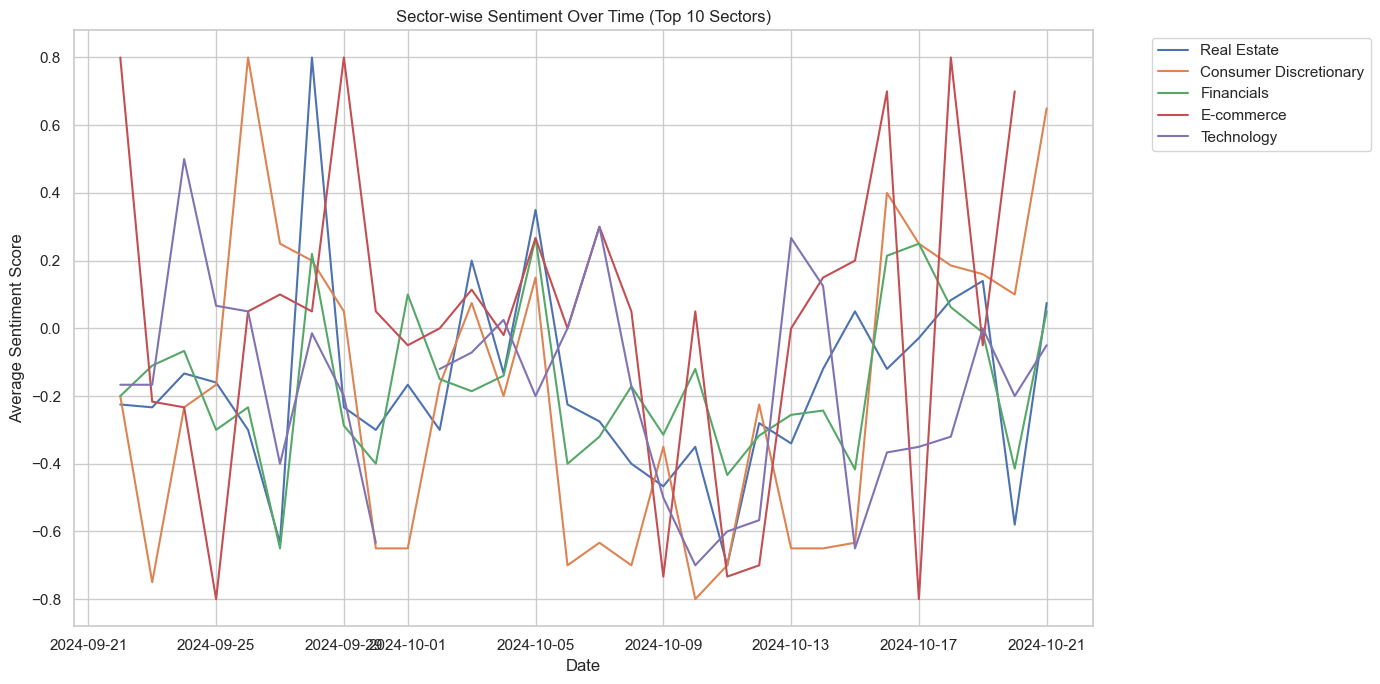

In [14]:
visualize_sector_timeseries()

### Detailed Sector Analysis Based on Sentiment Towards Recession Fears

#### Overview of All Sectors:
Here's the analysis for sectors with data on at least 20 different days, sorted by their average sentiment score:

| Sector                  | Average Sentiment Score | Sentiment Classification |
|-------------------------|-------------------------|--------------------------|
| Retail                  | 0.085                   | Neutral                  |
| Construction            | 0.040                   | Neutral                  |
| E-commerce              | 0.023                   | Neutral                  |
| Software                | 0.006                   | Neutral                  |
| Hardware                | -0.074                  | Neutral                  |
| Consumer Goods          | -0.092                  | Neutral                  |
| Media                   | -0.107                  | Neutral                  |
| Banking                 | -0.117                  | Neutral                  |
| Healthcare              | -0.164                  | Neutral                  |
| Financials              | -0.167                  | Neutral                  |
| Real Estate             | -0.168                  | Neutral                  |
| Technology              | -0.173                  | Neutral                  |
| Insurance               | -0.199                  | Neutral                  |
| Consumer Discretionary  | -0.204                  | Neutral                  |
| Consumer Staples        | -0.211                  | Neutral                  |
| Information Technology  | -0.258                  | Neutral                  |
| Energy                  | -0.267                  | Neutral                  |
| Pharmaceuticals         | -0.415                  | No fear                  |

This table shows that most sectors are classified as "Neutral" concerning recession fears, with "Pharmaceuticals" distinctly categorized as "No fear," indicating lower concerns about recession impacts within this sector.

#### Sectors with Extreme Sentiments:
- **Highest Average Sentiment**: The Transportation sector shows the highest positive average sentiment score of 0.241, classified as "Neutral," but leaning towards a positive outlook on recession fears, occurring 13 times.
- **Lowest Average Sentiment**: The Materials sector shows the lowest negative average sentiment score of -0.474, classified as "No fear," indicating a strong resilience or disregard towards recession fears, appearing 10 times.


---

## 14. Plot Sentiment Timeseries with Color-Coded Markers

The `plot_sentiment_timeseries` function generates a line plot of historical average sentiment scores over time and also adds color-coded markers based on predefined sentiment score ranges:

- **Green 'X'**: Sentiment scores between **-1** and **-0.33**
- **Yellow 'X'**: Sentiment scores between **-0.33** and **0.33**
- **Red 'X'**: Sentiment scores between **0.33** and **1**

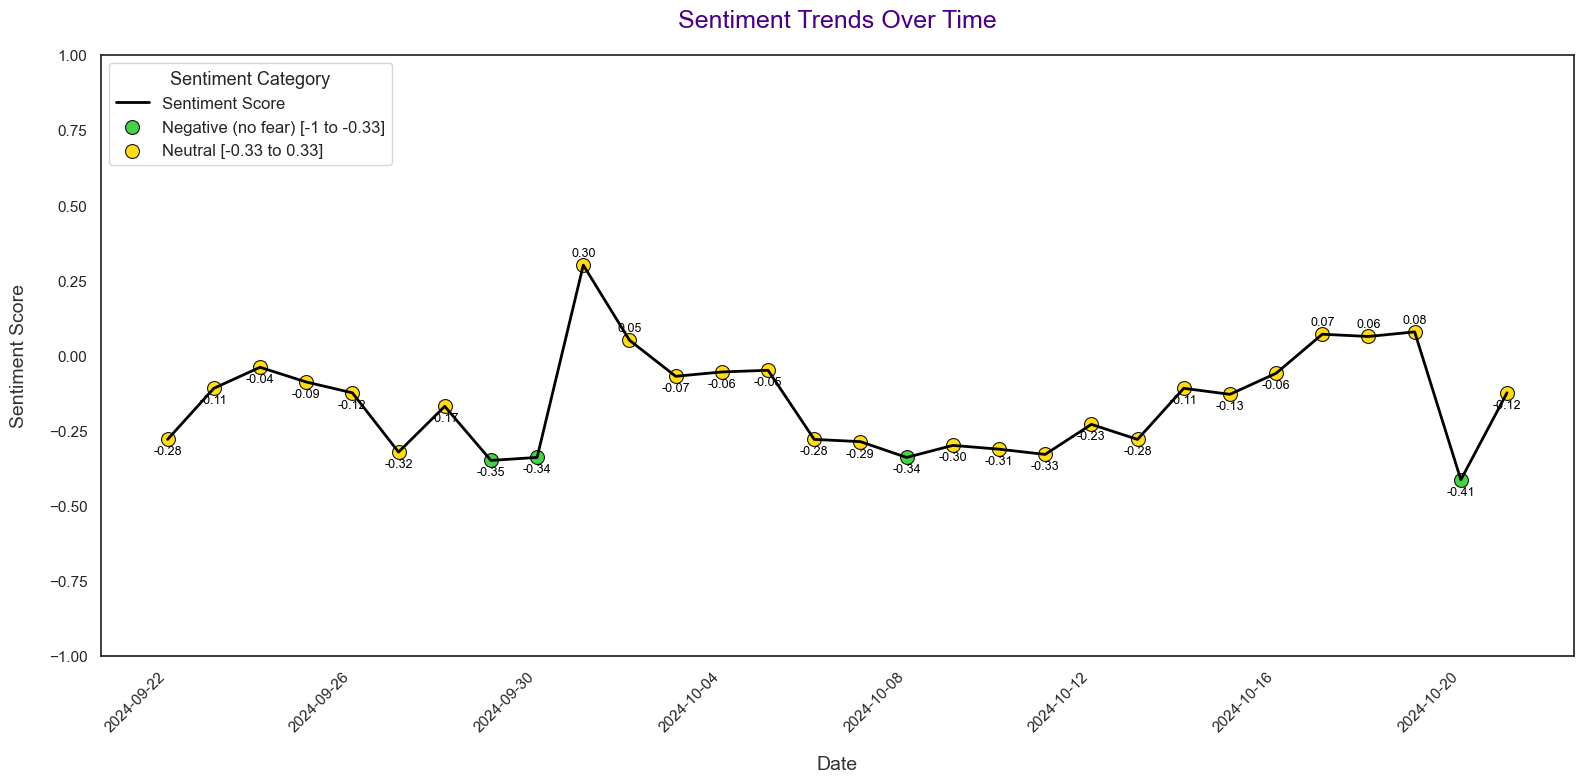

In [15]:
def plot_sentiment_timeseries(sentiment_csv='sentiment_timeseries.csv'):
    if not os.path.exists(sentiment_csv):
        print(f'Sentiment data file {sentiment_csv} not found.')
        return

    sentiment_df = pd.read_csv(sentiment_csv)
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
    sentiment_df.sort_values('date', inplace=True)

    sns.set(style='white', palette='pastel')
    plt.figure(figsize=(16, 8))
    sns.lineplot(data=sentiment_df, x='date', y='sentiment_score', label='Sentiment Score',
                 color='black', linewidth=2)

    conditions = [
        (sentiment_df['sentiment_score'] >= -1) & (sentiment_df['sentiment_score'] < -0.33),
        (sentiment_df['sentiment_score'] >= -0.33) & (sentiment_df['sentiment_score'] < 0.33),
        (sentiment_df['sentiment_score'] >= 0.33) & (sentiment_df['sentiment_score'] <= 1)
    ]

    colors = ['#32CD32', '#FFD700', '#FF6347']  # Tomato Red, Golden Yellow, Lime Green
    labels = ['Negative (no fear) [-1 to -0.33]', 'Neutral [-0.33 to 0.33]', ' Positive (fear) [0.33 to 1]']

    added_labels = set()

    for condition, color, label in zip(conditions, colors, labels):
        filtered_df = sentiment_df[condition]
        
        if label not in added_labels:
            sns.scatterplot(data=filtered_df, x='date', y='sentiment_score',
                            color=color, marker='o', s=100, label=label, edgecolor='black', alpha=0.9)
            added_labels.add(label)
        else:
            sns.scatterplot(data=filtered_df, x='date', y='sentiment_score',
                            color=color, marker='o', s=100, edgecolor='black', alpha=0.9)

        for idx, row in filtered_df.iterrows():
            plt.text(row['date'], row['sentiment_score'] + 0.03 if row['sentiment_score'] > 0 else row['sentiment_score'] - 0.05,
                     f"{row['sentiment_score']:.2f}", fontsize=9, ha='center', color='black')

    plt.xlabel('Date', fontsize=14, labelpad=15, color='#333333')
    plt.ylabel('Sentiment Score', fontsize=14, labelpad=15, color='#333333')
    plt.title('Sentiment Trends Over Time', fontsize=18, pad=20, color='#4B0082')

    plt.legend(title='Sentiment Category', fontsize=12, title_fontsize='13', loc='upper left')
    plt.ylim(-1, 1)
    plt.xticks(rotation=45, ha='right')
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

    plt.tight_layout()
    plt.show()

plot_sentiment_timeseries()

### Observations
- **Predominant Neutral Sentiment:** Most sentiment scores fall within the **neutral range (-0.33 to 0.33)**, indicating a balanced outlook without strong fear or reassurance regarding recession.

- **Scores Close to -0.33 (Leaning Towards No Fear):** Many sentiment scores are **close to -0.33**, leaning more towards **"Negative (no fear)"**. This suggests that while the sentiments are officially categorized as neutral, they tend to be slightly more optimistic about the absence of a recession.

- **Few Negative (no fear) Instances:** There are some dates where the sentiment score dips below -0.33, categorizing them as **Negative (no fear)**. For example, on **2024-10-20**, the sentiment score is **-0.414**, indicating less fear about a recession.

- **No Positive (fear) Instances:** There are no sentiment scores above 0.33 in this dataset, suggesting a lack of strong fear about recession during this period.

---

## 15. Plot Confidence Timeseries

Plots the historical average confidence scores over time.

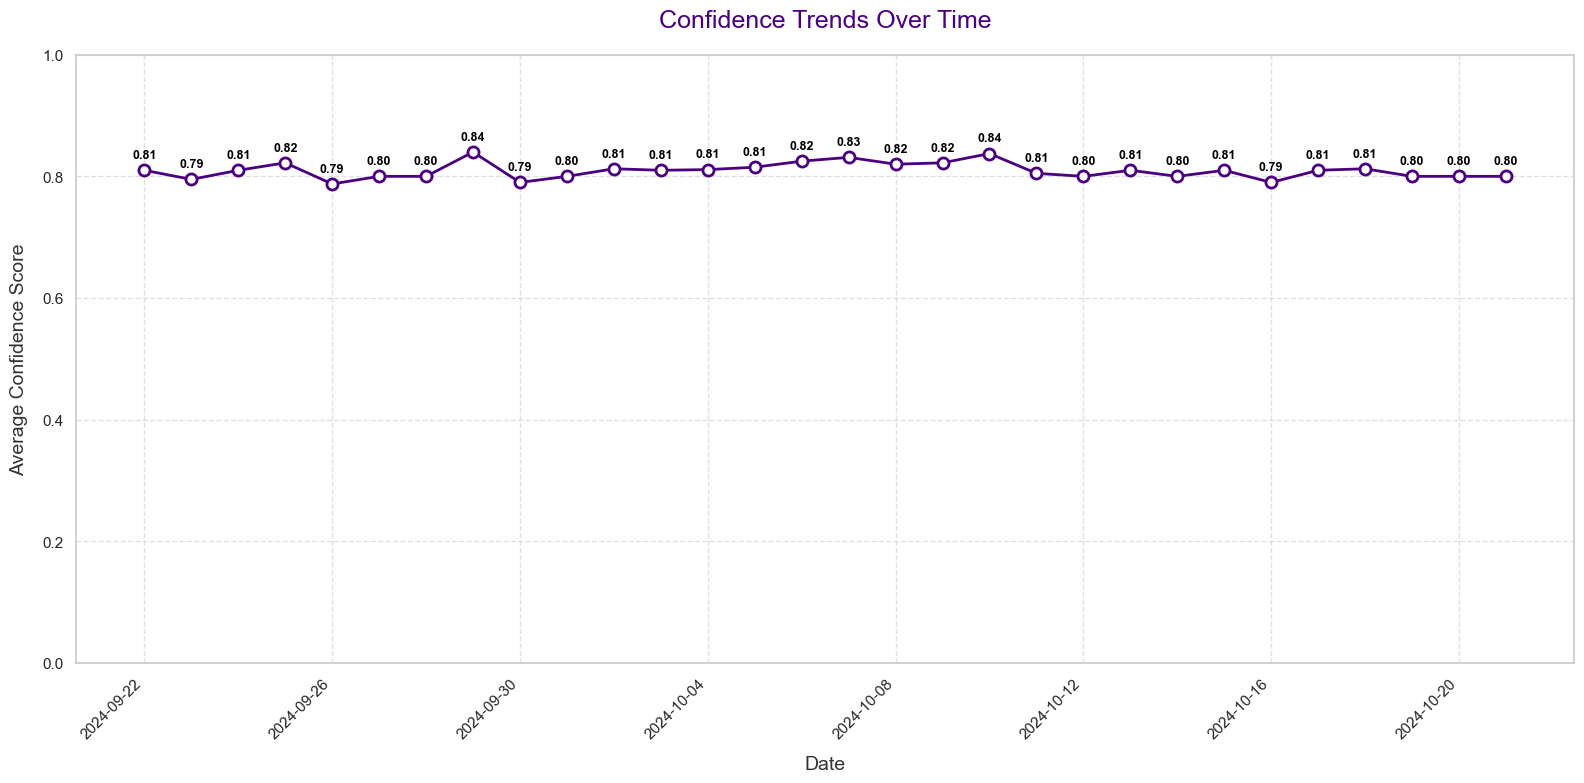

In [16]:
def plot_confidence_timeseries(sentiment_csv='sentiment_timeseries.csv'):

    if not os.path.exists(sentiment_csv):
        print(f'Sentiment data file {sentiment_csv} not found.')
        return
    confidence_df = pd.read_csv(sentiment_csv)
    confidence_df['date'] = pd.to_datetime(confidence_df['date'])
    confidence_df.sort_values('date', inplace=True)

    sns.set(style='whitegrid')
    plt.figure(figsize=(16, 8))

    sns.lineplot(data=confidence_df, x='date', y='confidence_score', marker='o', color='#4B0082',
                 linewidth=2, markersize=8, markerfacecolor='white', markeredgewidth=2, markeredgecolor='#4B0082')

    plt.xlabel('Date', fontsize=14, labelpad=10, color='#333333')
    plt.ylabel('Average Confidence Score', fontsize=14, labelpad=10, color='#333333')
    plt.title('Confidence Trends Over Time', fontsize=18, pad=20, color='#4B0082')
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right')
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

    for idx, row in confidence_df.iterrows():
        plt.text(row['date'], row['confidence_score'] + 0.02, f"{row['confidence_score']:.2f}",
                 fontsize=9, ha='center', color='black', weight='bold')

    # Tight layout for better aesthetics
    plt.tight_layout()
    plt.show()

plot_confidence_timeseries()


### Observations

- **High Confidence Levels:** The confidence scores are consistently high, with an average of approximately **0.807**, indicating that the sentiment analyses are reliable.

- **Stable Confidence Over Time:** Confidence scores remain relatively stable over the period, with minor fluctuations.

- **Weak Correlation:** The correlation between sentiment scores and confidence shows a weak positive relationship. This implies that higher confidence does not necessarily correspond to higher (more positive) sentiment scores.

---

## **16. Comparison of Confidence Scores with Fear and Greed Index**

In this section, I compared sentiment analysis confidence scores (scaled up by multiplying by 100) with the **Fear and Greed Index** to understand how sentiment data aligns with broader market sentiments. The **Fear and Greed Index** data was retrieved from [CNN's Fear and Greed Index](https://edition.cnn.com/markets/fear-and-greed), which tracks the emotions driving the market.

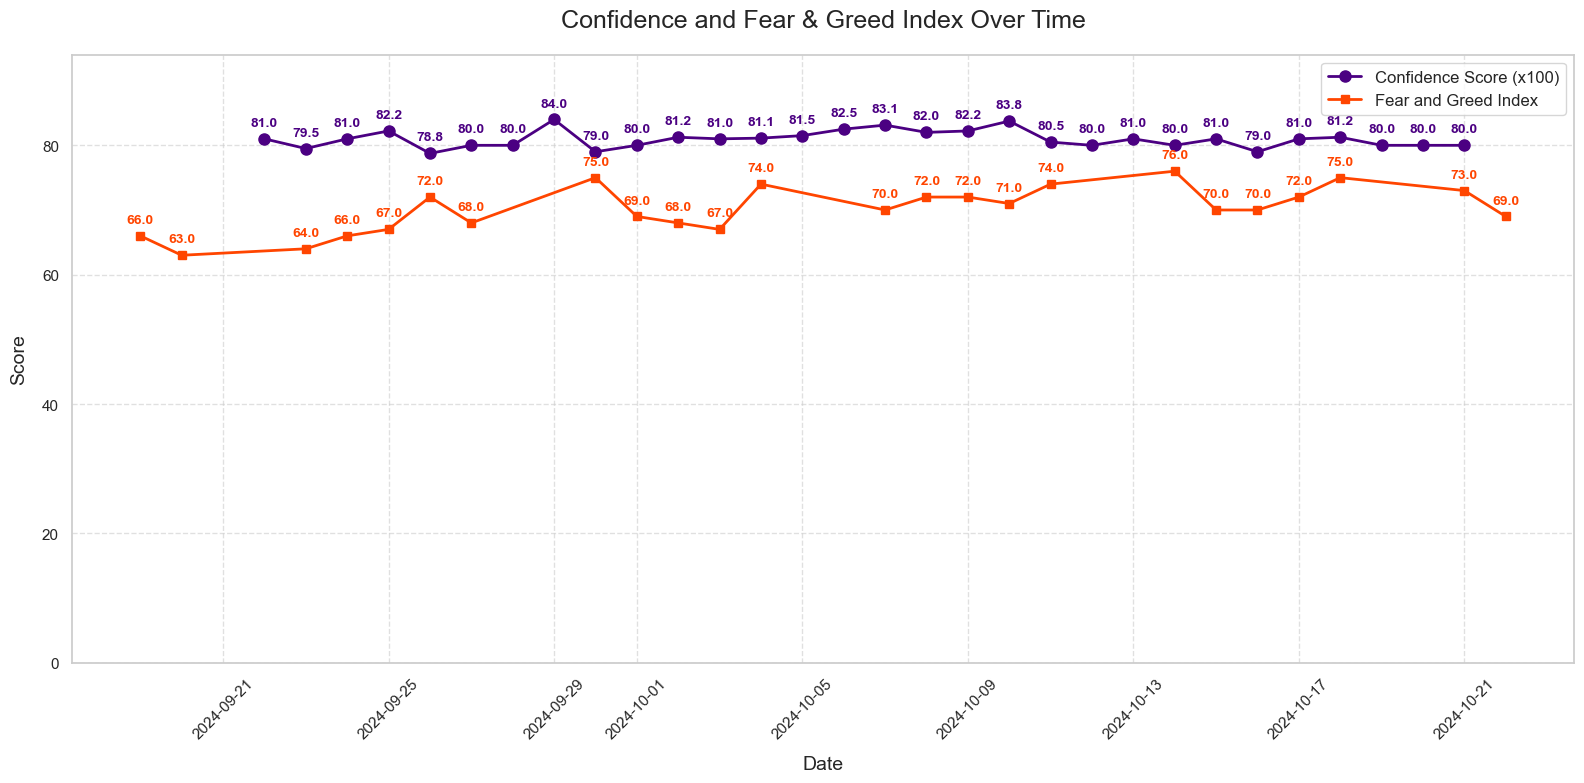

In [ ]:
def plot_confidence_timeseries_adjusted(sentiment_csv='sentiment_timeseries.csv', fear_greed_csv='fear_and_greed_index.csv'):

    confidence_df = pd.read_csv(sentiment_csv)
    confidence_df['date'] = pd.to_datetime(confidence_df['date'])
    confidence_df.sort_values('date', inplace=True)
    
    fear_greed_df = pd.read_csv(fear_greed_csv)
    fear_greed_df['Date'] = pd.to_datetime(fear_greed_df['Date'])
    fear_greed_df.sort_values('Date', inplace=True)

    confidence_df['confidence_score'] = confidence_df['confidence_score'] * 100

    plt.figure(figsize=(16, 8))

    plt.plot(confidence_df['date'], confidence_df['confidence_score'], marker='o', color='#4B0082',
             linewidth=2, markersize=8, label='Confidence Score (x100)')

    plt.plot(fear_greed_df['Date'], fear_greed_df['Index Value'], marker='s', color='#FF4500',
             linewidth=2, markersize=6, label='Fear and Greed Index')

    for idx, row in confidence_df.iterrows():
        plt.text(row['date'], row['confidence_score'] + 2, f"{row['confidence_score']:.1f}", 
                 fontsize=10, ha='center', color='#4B0082', weight='bold')

    for idx, row in fear_greed_df.iterrows():
        plt.text(row['Date'], row['Index Value'] + 2, f"{row['Index Value']:.1f}", 
                 fontsize=10, ha='center', color='#FF4500', weight='bold')

    plt.xlabel('Date', fontsize=14, labelpad=10)
    plt.ylabel('Score', fontsize=14, labelpad=10)
    plt.title('Confidence and Fear & Greed Index Over Time', fontsize=18, pad=20)
    plt.ylim(0, max(confidence_df['confidence_score'].max(), fear_greed_df['Index Value'].max()) + 10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.show()

plot_confidence_timeseries_adjusted()


### **Analysis and Observations**

- **Comparison Overview:**
  - The confidence scores (scaled to 0-100) and the Fear and Greed Index values are plotted over time to observe any correlations or discrepancies.

- **Confidence Scores:**
  - The confidence scores remain relatively stable over time, ranging approximately between **78.7** and **84.0**.

- **Fear and Greed Index:**
  - The Fear and Greed Index values range from **63** to **76**, indicating a market leaning towards **"Greed"** during this period.

- **Interpretation:**
  - The stable and high confidence scores indicate that the sentiment analysis is reliable during this period, though the sentiments themselves (as analyzed in previous sections) lean towards neutral or slightly **"no fear"** regarding recession.

- **Overall Market Alignment:** The generally positive market data aligns with the sentiment analysis findings. Since the Fear and Greed Index reflects market optimism, and the sentiment scores lean towards **"no fear"** of recession, this concurrence suggests that analyses are close to accurate.



---

## 17. Methodology

In this project, I conducted a sentiment analysis to assess recession fears across various sectors over a specified time period. The main steps of my methodology are as follows:

1. **Data Collection:**
   - **News Articles Retrieval:** I utilized the **News API** to gather news articles related to recession fears and specific sectors. Due to the limitations of the free version of the API, I was able to collect articles from the past one month, with a maximum of 10 articles per day.
   - **Data Storage:** Collected articles and data were saved for further analysis. This ensured data consistency and facilitated the analysis process without repeatedly querying the API.

2. **Data Preprocessing:**
   - **Text Cleaning:** The text data from the articles were cleaned to remove irrelevant information such as HTML tags, special characters, and stop words.
   - **Sentiment Scoring:** Each article was analyzed using a sentiment analysis model to obtain a sentiment score ranging from **-1** to **1**.

3. **Sentiment Categorization:**
   - The sentiment scores were categorized into three groups based on the following thresholds:
     - **Negative Sentiment (No Fear):** Scores between **-1** and **-0.33**.
     - **Neutral Sentiment:** Scores between **-0.33** and **0.33**.
     - **Positive Sentiment (Fear):** Scores between **0.33** and **1**.

4. **Data Visualization:**
   - **Time Series Analysis:** Sentiment scores were plotted over time to observe trends and patterns.
   - **Sector Analysis:** Sentiment trends were analyzed across different sectors to identify sector-specific concerns or optimism.
   - **Comparison with Market Indicators:** The sentiment scores were compared with the **Fear and Greed Index** to validate my findings against broader market sentiments.


---

## 16. Challenges

During the execution of this project, I encountered several challenges that impacted my methodology and analysis:

1. **Token Usage and Model Limitations:**
   - Initially, I utilized the **GPT-4o** model for sentiment analysis. However, due to high token consumption, which quickly reached the $10 limit, I had to switch to the **GPT-3.5 Turbo** model to continue my analysis within budget constraints.

2. **News API Limitations:**
   - **Time Frame Restrictions:** The **News API** free version only allows access to articles from the past one month, limiting the historical depth of my analysis.
   - **Article Limitations:** The free version restricts the number of articles that can be retrieved per day. To maximize the number of articles analyzed (up to 10 articles per day), I had to create multiple accounts. With a paid subscription, I could have accessed more articles for a more detailed and comprehensive analysis.

3. **Efficiency Considerations:**
   - **Data Saving and API Management:** Due to the limitations of the News API, I needed to save the retrieved data and manage different API keys from multiple accounts. This added complexity to the data collection process.
   - **Batch Processing Not Required:** The limited number of articles available in the free version meant that batch processing was unnecessary. While batch processing can enhance efficiency when analyzing large volumes of data, it was not applicable in my case due to the restricted dataset size.

Despite these challenges, I successfully conducted the sentiment analysis and provided insights into recession fears across various sectors. The generally positive market data, as indicated by the **Fear and Greed Index** leaning towards **"Greed,"** aligns with my sentiment analysis findings of neutral to slightly **"no fear"** sentiments regarding recession. This match shows that my analyses are accurate and reflective of the current economic climate.

Future work could benefit from access to more extensive data and resources to enhance the depth and breadth of the analysis. With a paid News API subscription, I could analyze a larger number of articles over a more extended period, potentially incorporating batch processing techniques to improve efficiency.